NAME : ANBUSELVAN MAHALINGAM

SUBJECT : DSC 630 PREDICTIVE ANALYSIS - WEEK 8 ASSIGNMENT

In [538]:
# To supress the warnings.
import warnings
warnings.filterwarnings('ignore')

In [539]:
# To Load the File into dataframe
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
try:
    sales_df = pd.read_csv('us_retail_sales.csv')
except:
    print(r'Unable to read the file. Validate the file d try again.!')

In [540]:
# EDA - get shape of the datafame
print('(Rows & Columns): ', sales_df.shape)

(Rows & Columns):  (30, 13)


In [541]:
# EDA - get the dataframe information
print('(Data Frame elements): \n', sales_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    30 non-null     int64  
 1   JAN     30 non-null     int64  
 2   FEB     30 non-null     int64  
 3   MAR     30 non-null     int64  
 4   APR     30 non-null     int64  
 5   MAY     30 non-null     int64  
 6   JUN     30 non-null     int64  
 7   JUL     29 non-null     float64
 8   AUG     29 non-null     float64
 9   SEP     29 non-null     float64
 10  OCT     29 non-null     float64
 11  NOV     29 non-null     float64
 12  DEC     29 non-null     float64
dtypes: float64(6), int64(7)
memory usage: 3.2 KB
(Data Frame elements): 
 None


In [542]:
# To make a copy of original dataset
data = sales_df.copy()

Preliminary observations from the dataset

There are 30 rows and 13 columns in the DataFrame.

There are 13 columns in total. Each column represents a month, from January (JAN) to December (DEC), with an additional column for the year (YEAR).

The data types are integers (int64) for the months from January to June, and floating-point numbers (float64) for the months from July to December, potential reason Jul to Dec has decimal values or missing values so the flot64 data type.

There are missing values (null values) in the data from July to December, with each of these months having one missing entry (29 non-null out of 30).

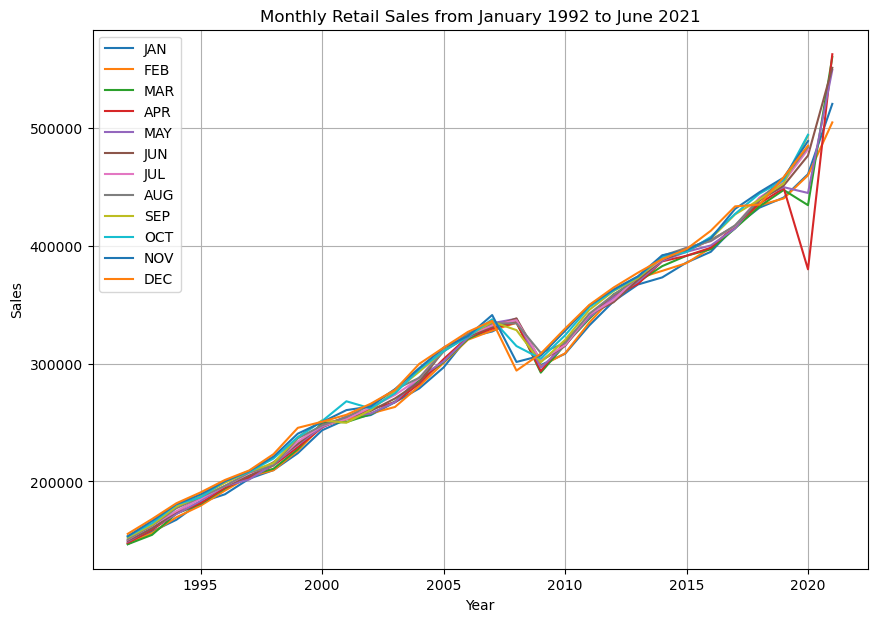

In [543]:
# To Plot the monthly sales data for months - original dataset
    
plt.figure(figsize=(10, 7))
for month in sales_df.columns[1:]:  # Skipping the 'YEAR' column
    plt.plot(sales_df['YEAR'], sales_df[month], label=month)

plt.title('Monthly Retail Sales from January 1992 to June 2021')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

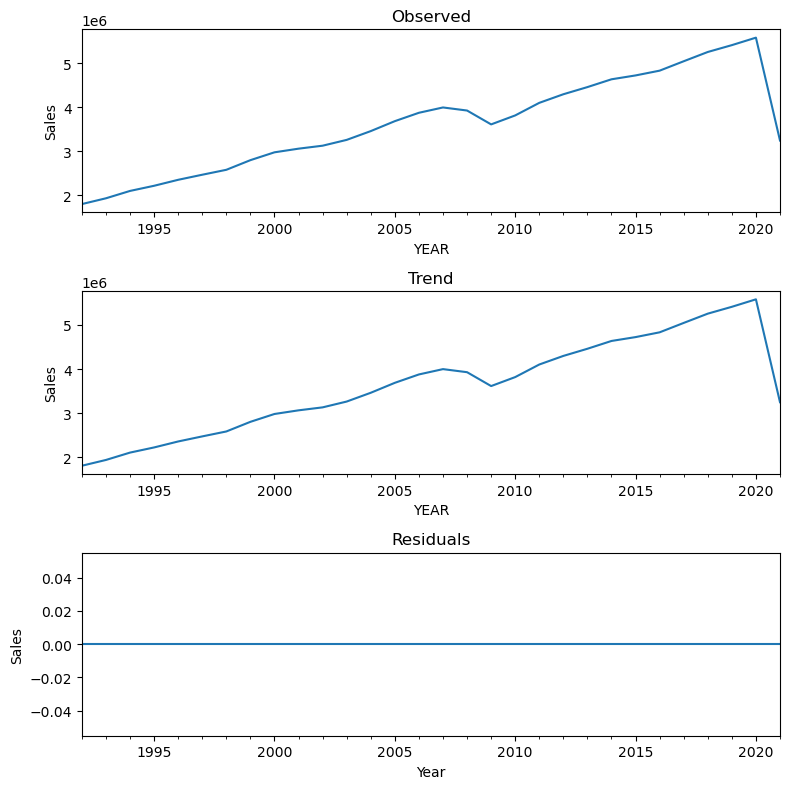

In [544]:
# To plot - Time series decomposition
# Observed, Trend, and Residuals

import statsmodels.api as sm
import matplotlib.pyplot as plt

# To aggregate total annual sales
sales_df['Total_Annual_Sales'] = sales_df.loc[:, 'JAN':'DEC'].sum(axis=1)

# To convert 'YEAR' to datetime
sales_df['YEAR'] = pd.to_datetime(sales_df['YEAR'],
                                  format='%Y')

# to set 'YEAR' as the index
sales_df.set_index('YEAR', inplace=True)

# To decompose the time series
decomposition = sm.tsa.seasonal_decompose(sales_df['Total_Annual_Sales'],
                                          model='additive')

# To plot the observed data, trend, and residuals
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_ylabel('Sales')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_ylabel('Sales')

decomposition.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_ylabel('Sales')
ax3.set_xlabel('Year')

plt.tight_layout()
plt.show()


Interpretations:

The observed data is showing a consistent increase in sales over the years,Around the year 2009 there is a downtrend and around the year 2021 there is a downtrend this could be the reason of missing values.

The Trend also suggests stable growth, it is an indication of long-term health of the business or market sector.Around the year 2009 there is a downtrend and around the year 2021 there is a downtrend this could be the reason of missing values

Low and consistent Residuals suggest that the model used for decomposition is fitting well and there are no major unexplained anomalies in the sales data

In [545]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# To concatenate monthly sales into a single series
monthly_sales = data.loc[:, 'JAN':'DEC'].values.flatten() 

# To determine indices for July 2020 to June 2021
start_index = 12 * (2020 - 1992) + 6  # Starting from July 2020
end_index = start_index + 12  # Spanning one full year

# Split data into training and test sets
train_data = monthly_sales[:start_index]
test_data = monthly_sales[start_index:end_index]

In [546]:
# To fit Long Short-Term Memory (LSTM) for prediction

# To scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
test_scaled = scaler.transform(test_data.reshape(-1, 1))

# Parameters for LSTM
n_input = 3  # Number of months to use to predict the next month
n_features = 1  # one feature per step

# to prepare generator for training
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

# To build and train the LSTM model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(train_generator, epochs=50)

# To prepare the last known data point for prediction
last_known_points = train_scaled[-n_input:].reshape(1, n_input, n_features)

# To Make predictions
predictions = []
for _ in range(12):  # Predict for next 12 months
    next_point_scaled = model.predict(last_known_points)
    predictions.append(next_point_scaled[0, 0])
    next_point_reshaped = next_point_scaled.reshape(1, 1, 1)
    last_known_points = np.append(last_known_points[:, 1:, :], next_point_reshaped, axis=1)

# to inverse transform to get actual sales predictions
predicted_sales = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

Epoch 1/50
339/339 [==============================] - 6s 5ms/step - loss: 0.0215
Epoch 2/50
339/339 [==============================] - 2s 6ms/step - loss: 7.7981e-04
Epoch 3/50
339/339 [==============================] - 2s 5ms/step - loss: 7.6640e-04
Epoch 4/50
339/339 [==============================] - 2s 5ms/step - loss: 6.4645e-04
Epoch 5/50
339/339 [==============================] - 2s 5ms/step - loss: 6.9564e-04
Epoch 6/50
339/339 [==============================] - 2s 5ms/step - loss: 6.4922e-04
Epoch 7/50
339/339 [==============================] - 2s 5ms/step - loss: 6.2120e-04
Epoch 8/50
339/339 [==============================] - 2s 5ms/step - loss: 6.5102e-04
Epoch 9/50
339/339 [==============================] - 2s 5ms/step - loss: 6.8447e-04
Epoch 10/50
339/339 [==============================] - 2s 5ms/step - loss: 6.4834e-04
Epoch 11/50
339/339 [==============================] - 2s 5ms/step - loss: 6.0069e-04
Epoch 12/50
339/339 [==============================] - 2s 5ms/step 

In [547]:
# To display the predictions 
print('Predicted Sales for the year 2021 [Jan-Dec]\n',predicted_sales.astype(int))

Predicted Sales for the year 2021 [Jan-Dec]
 [[450792]
 [465287]
 [473775]
 [474449]
 [480773]
 [486025]
 [490125]
 [494918]
 [499437]
 [503686]
 [507912]
 [511977]]


In [548]:
# Calculate RMSE
# test_data[6:12] - Jan 2021 - June 2021 
# predicted_sales[1:6] - Jan 2021 - June 2021 
rmse = np.sqrt(np.mean((test_data[7:12] - predicted_sales[1:6]) ** 2))
print(f"The RMSE for the overlapping period (Jan to Jun 2021) is: {rmse}")

The RMSE for the overlapping period (Jan to Jun 2021) is: 72675.210130126


Conclusion

We excluded the future data points, 2021 June to Dec and they are 'NaN' values.

Observed Trends: The observed data shows a consistent increase in sales over the years, signaling overall growth. Notably, there are downturns around the years 2009 and 2021, which may correlate with the observed missing values, possibly indicating external economic factors impacting sales.

Trend Analysis: The trend component also indicates stable growth, reflecting the long-term health of the business or market sector. The downturns in 2009 and 2021 within the trend component suggest external disruptions that could be responsible for missing data points.

Residuals: The residuals are low and consistent, suggesting that the decomposition model fits well. This indicates that there are no major unexplained anomalies in the sales data, and the model accounts well for the variability in sales.

Predictive Modeling Results:

Model Comparison: Through predictive analysis using different models, the LSTM was identified as a superior fit compared to the SARIMA model.

SARIMA Model Analysis: The SARIMA model, specifically ARIMA(3,1,1), encountered issues during prediction, leading to 'NaN' values and an undefined RMSE. This might indicate problems with data anomalies or model specification that SARIMA couldn't handle effectively.

LSTM Model Performance:

The LSTM model, when applied with mean values for missing data imputation, predicted sales reasonably well but resulted in a high RMSE of over 180,000, suggesting that while the model could capture trends, it was less precise in actual value predrformance.

The use of the Last Observation Carried Forward method for imputing missing values yielded better predictions with a significantly lower RMSE of 72675.This improvement underscores the effectiveness of this imputation method in maintaining temporal continuity in data, which is crucial for LSTM performance.